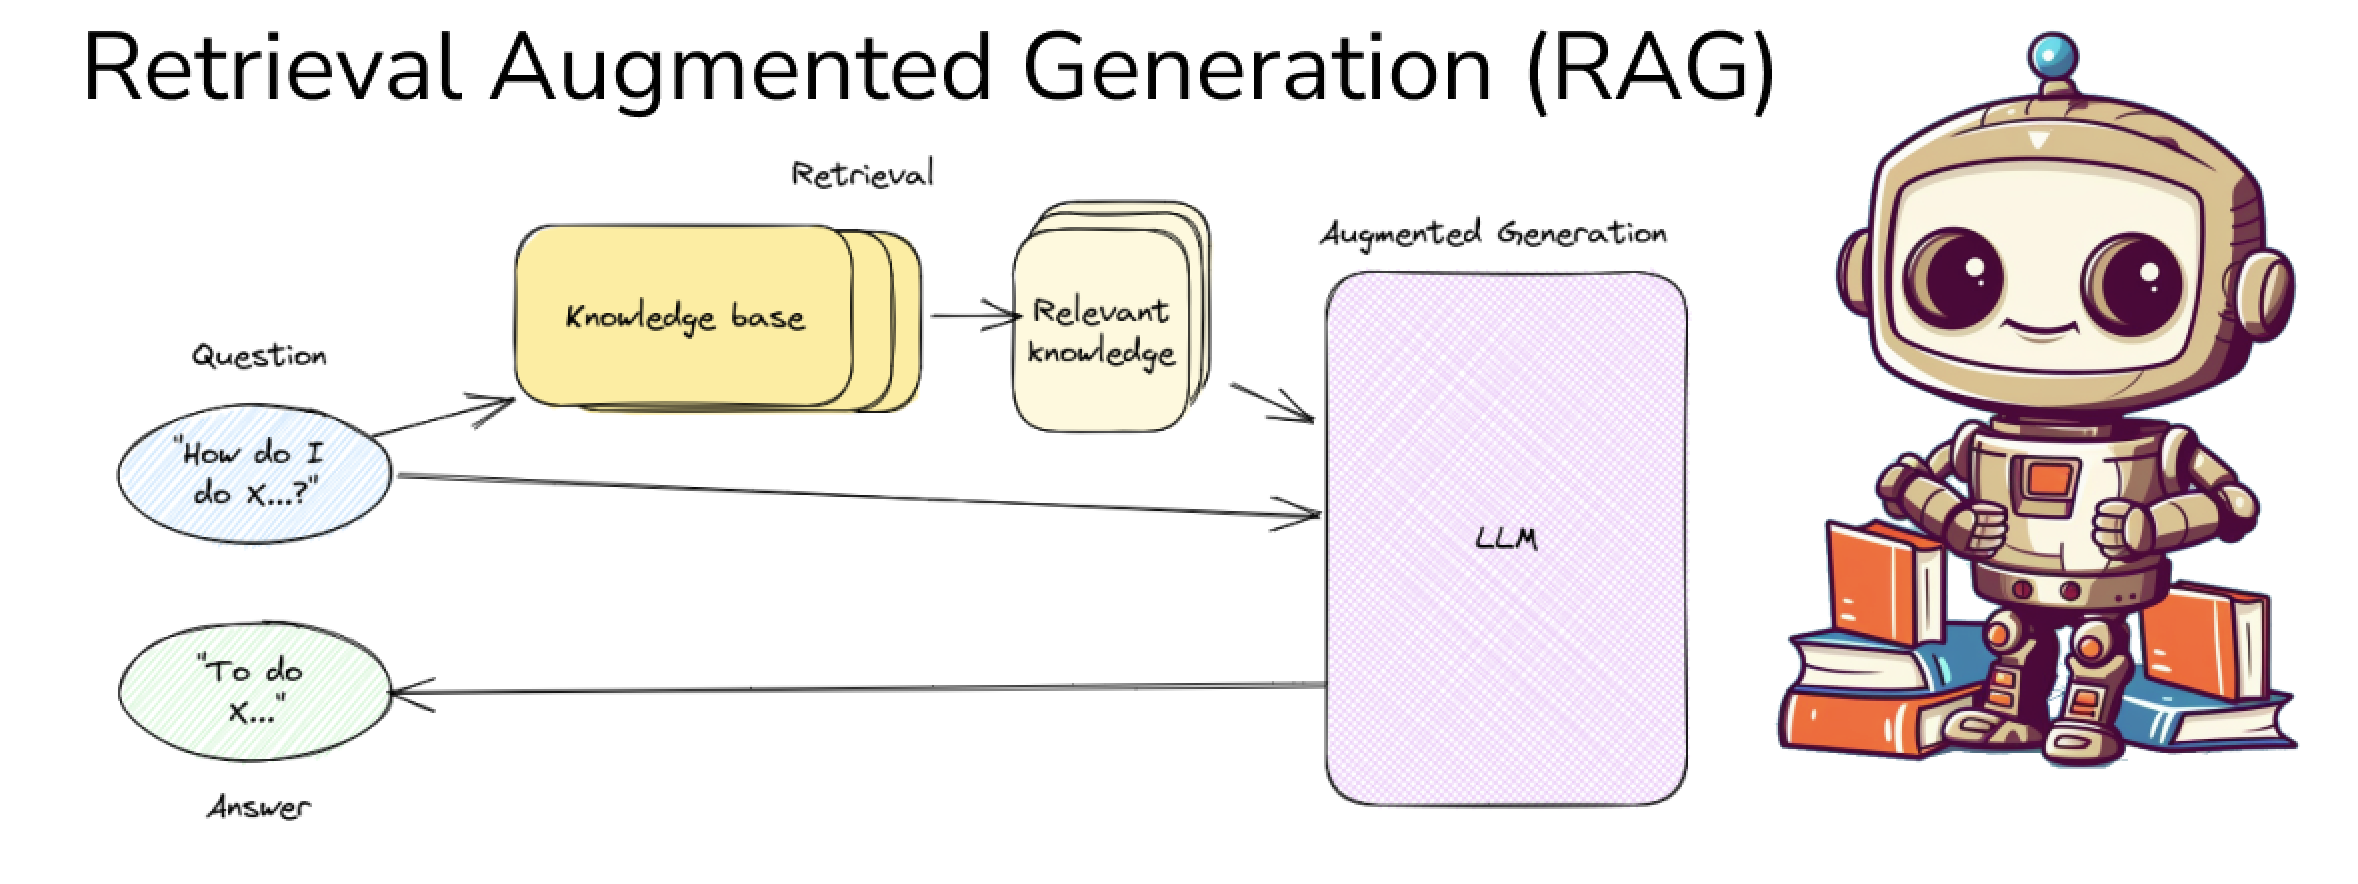

As we saw during the presentation, RAG (aka Retrieval Augmented Generation) combines pretrained generative models, namely LLMs, with other sources in order to improve the quality and relevance of the generated responses.

 In the following, we will code our very own Chatbot application step by step using an open source model, namely llma3 from Meta, to query a particular Wikipedia page.

## Step 1: Initial setup

### **WARNING**
Before starting anything, make sure you select a GPU runtime within colab. The T4 GPU runtime can be used for free.

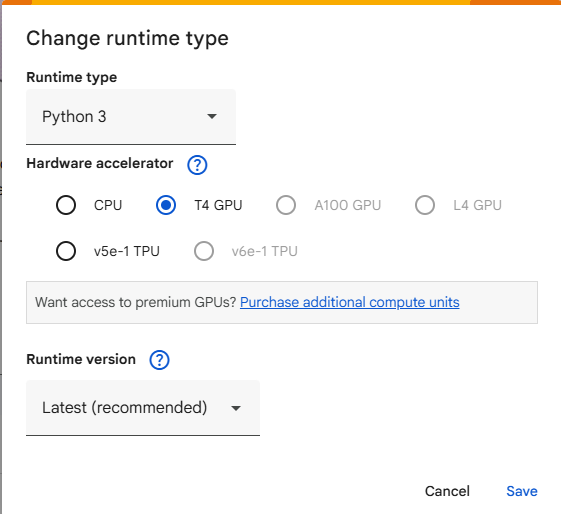

First of all, we need to install all the needed Python libraries using pip.

Before using an open source model, it is necessary to download it locally. On your own computer you'd do so using specific commands in a terminal. This process can be reproduced in colab environments using the colab-xterm library.

In [1]:
!pip install colab-xterm
%load_ext colabxterm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.6/115.6 kB 4.5 MB/s eta 0:00:00


Running the following cell will then open a terminal, that will allow us to use Ollama. This is simly a tool for running open source language models locally. Afterwards, we'll be able to take advantage of any model included in Ollama, llama3 in this case.

In [ ]:
# Type these commands successively in below terminal after run the cell %xterm
# curl -fsSL https://ollama.com/install.sh | sh
# ollama serve & ollama pull llama3 & ollama pull nomic-embed-text (maybe twice)

In [2]:
%xterm

Launching Xterm...

<IPython.core.display.Javascript object>

Then we need to install LangChain, a software framework that helps facilitate the integration of LLMs into applications.

In [3]:
!pip install langchain
!pip install langchain-core
!pip install langchain-community
!pip install langchain-ollama
!pip install chromadb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 43.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.8 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.4
    Uninstalling requests-2.32.4:
      Successfully uninstalled requests-2.32.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 3.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.8/19.8 MB 78.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Let's now test if llama3 can be used in our colab environment.

In [4]:
from langchain_ollama import OllamaLLM
llm = OllamaLLM(model = "llama3")
llm.invoke("what is the Meaning of life")

"The meaning of life! This is a question that has puzzled philosophers, scientists, and ordinary people for centuries. There is no one definitive answer, as it ultimately depends on individual perspectives, beliefs, and values. Here are some possible answers:\n\n1. **Purpose**: The meaning of life might be found in our purpose or the reason we exist. For some, this could be a sense of fulfillment, happiness, or contribution to society.\n2. **Happiness**: Some argue that the meaning of life is to maximize one's own happiness and well-being. This perspective emphasizes self-care, self-love, and personal growth.\n3. **Knowledge and understanding**: Others believe that the meaning of life lies in the pursuit of knowledge, wisdom, and truth. This perspective values intellectual curiosity and the quest for answers about the universe and our place within it.\n4. **Connection with others**: For many people, the meaning of life is found in relationships with family, friends, community, or even 

In [5]:
import gradio as gr
import ollama
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_ollama import OllamaEmbeddings
from langchain.schema import Document

In the following, we will code our very own Chatbot application step by step using an open source model, namely llma3 from Meta, to query a particular Wikipedia page.

## Step 2: Load data

Now that everything is set up, we can start by loading the external source that will be employed in our RAG Chatbot. For the sake of this session, we will query the Wikipedia page of Ada Lovelace, our spiritual mother.

In [6]:
url = 'https://en.wikipedia.org/wiki/Ada_Lovelace' # can be changed to whatever you want
loader = WebBaseLoader(url)
docs = loader.load()

In [7]:
print(f"There are {len(docs[0].page_content)} characters in Ada Lovelace's Wikipedia page.\n")

There are 74981 characters in Ada Lovelace's Wikipedia page.



We can see that the number of characters is quite large and that we will not be able to put the entire document in the prompt to ask our questions.

## Step 3: Split data into chunks

Since large language models (LLMs) can only process a limited amount of information at a time (the context), we split our documents into smaller, more manageable chunks. This allows our model to process the information more efficiently and quickly.

![image](https://implementconsultinggroup.imgix.net/uploads/articles/2024/Building-high-quality-RAG-systems/240227_Fig_Building-high-quality-RAG-systems_JEAL4.png?auto=compress%2Cformat&fit=clip&q=75&w=2600)

In [8]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=0)

text_content = docs[0].page_content
text_content = text_content.replace(" \n  \n", '\n\n')

n = "\n "
for i in range(100, 0, -1):
    back_slash_string = n * i + "\n"
    text_content = text_content.replace(back_slash_string, '\n\n')

documents_chunks = text_splitter.split_text(text_content)

documents_chunks = [Document(page_content=chunk, metadata={'source': f'Wikipedia Ada Lovelace, part_{idx}'})
                    for idx, chunk in enumerate(documents_chunks)]

print("# of chunks: ", len(documents_chunks))

# of chunks:  107


Let's write a small function to see how those 1000-character chunks look like.

In [9]:
def print_chunk(document_chunk):
  content = document_chunk.page_content
  print(f"'''\n{content}\n'''", len(content))
  print(document_chunk.metadata)

print_chunk(documents_chunks[5]) # range from 0 to 106

'''
Augusta Ada King, Countess of Lovelace (née Byron; 10 December 1815 – 27 November 1852), also known as Ada Lovelace, was an English mathematician and writer chiefly known for her work on Charles Babbage's proposed mechanical general-purpose computer, the Analytical Engine. She was the first to recognise that the machine had applications beyond pure calculation. Ada Lovelace is sometimes  considered to be the first computer programmer.
''' 438
{'source': 'Wikipedia Ada Lovelace, part_5'}


## Step 4: create Ollama embeddings and vector stores

Now that we have split our document into smaller pieces, we need to find a way to store the information efficiently. The idea is that when we ask a question, we want to retrieve the most relevant parts of the document that could be useful for answering the question.

This is where vectors come into play. It's possible to translate our documents into vector representations that preserve the semantics of the document (i.e., the meaning), which is called embeddings. According to this principle, documents with similar meanings will have similar vectors. This will allow us, in particular, to calculate the similarity between documents and a user's question.

A vector store refers to a data structure or database that stores pre-calculated vector representations (embeddings) of documents/texts. The vector store enables efficient similarity search between user queries and stored sources, allowing our application to retrieve relevant documents based on their semantic similarity to the user's question.

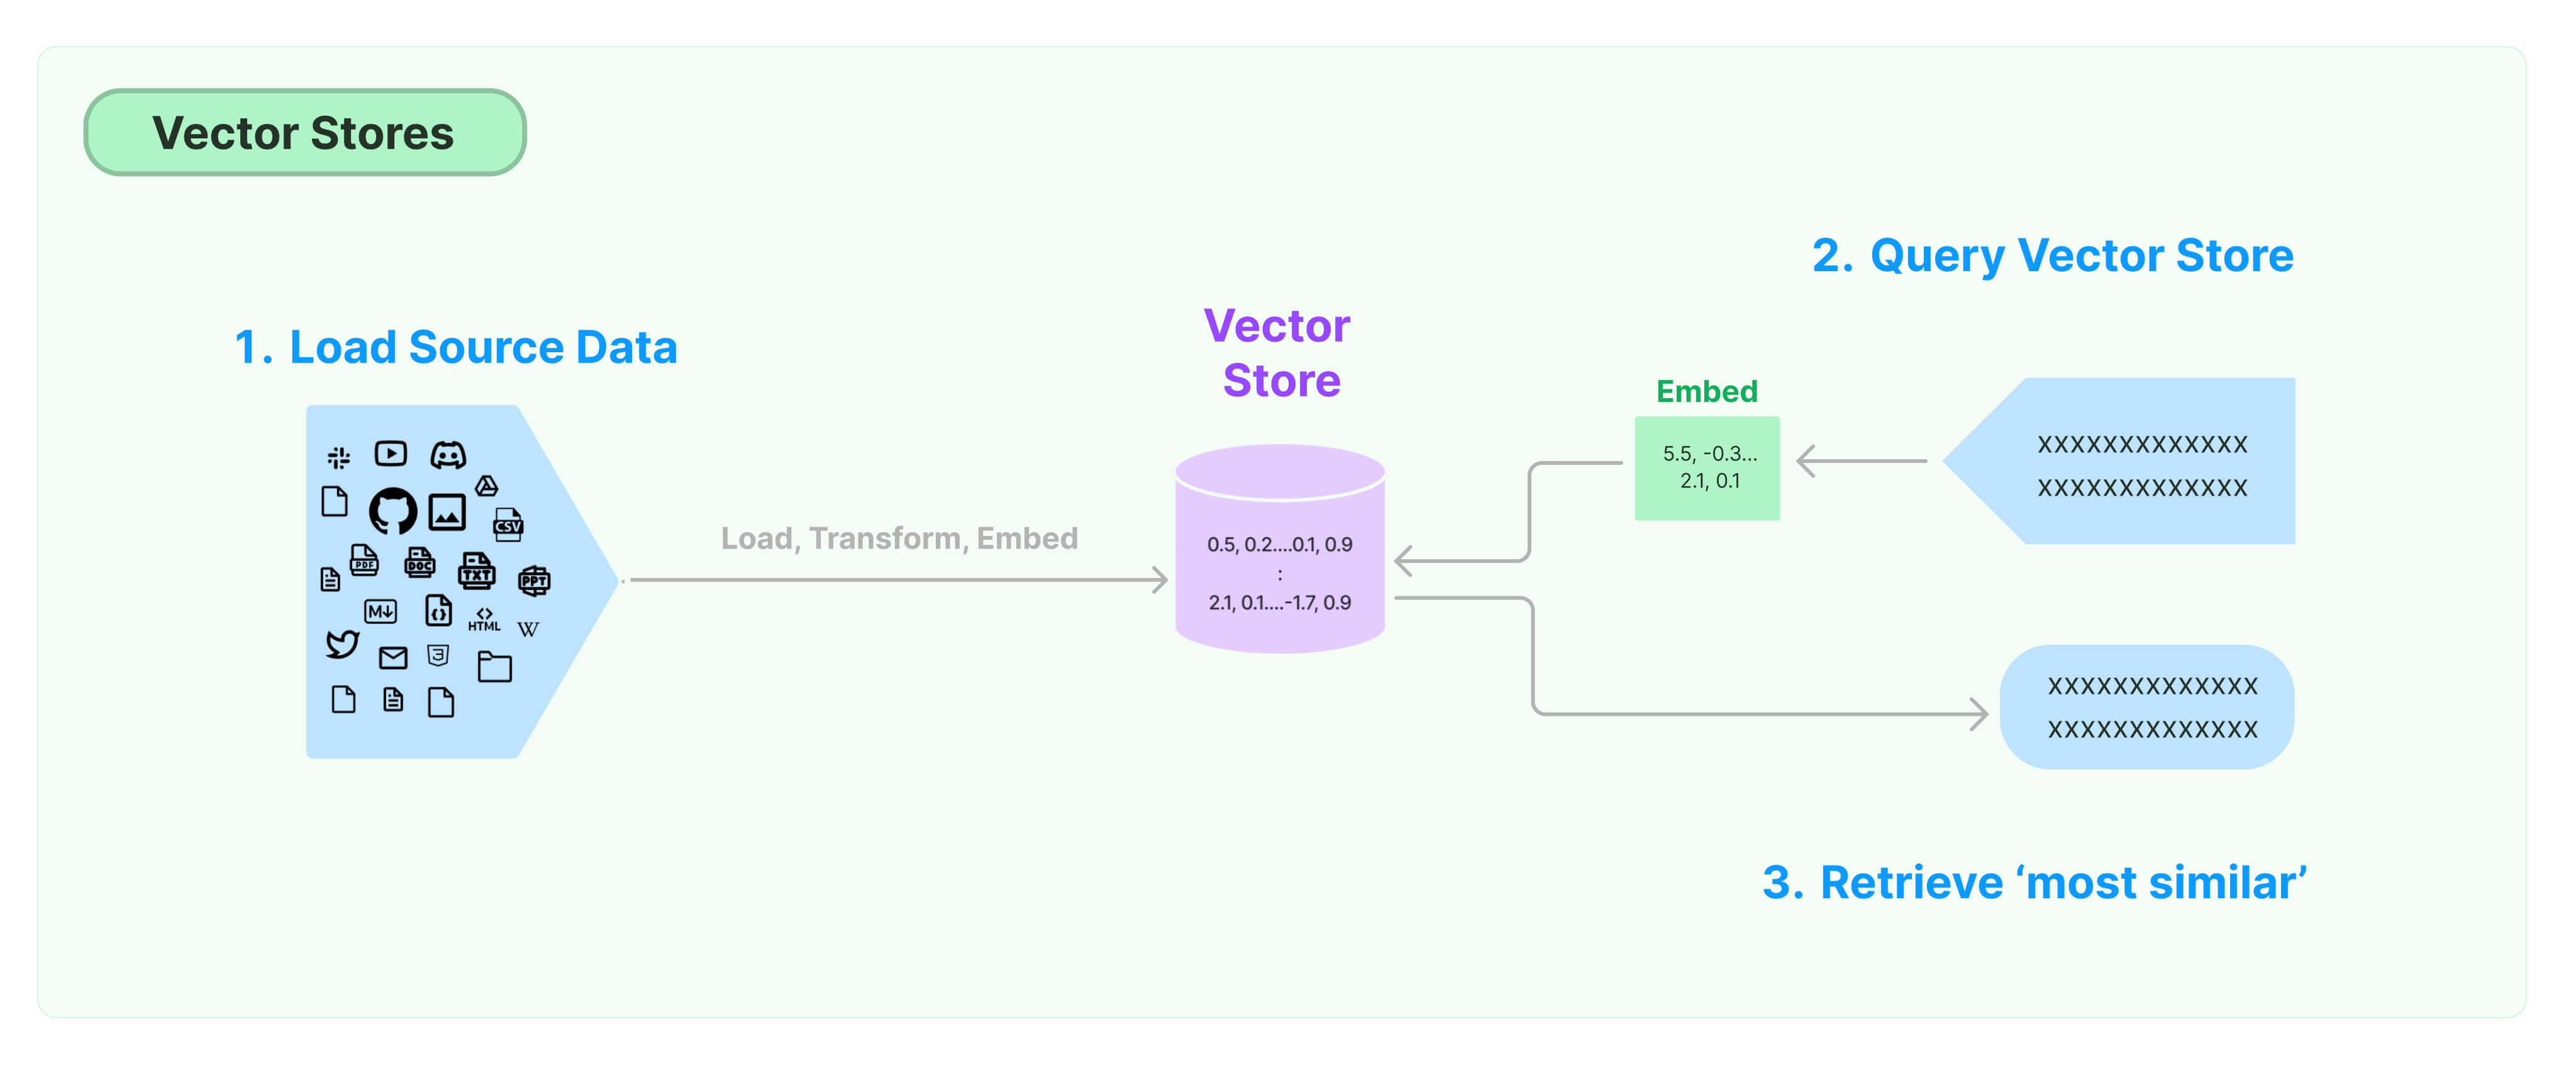

To calculate the similarity between two vectors and thus know which documents we will use, we will use the Euclidean distance which corresponds to the distance between two points in a graph.

As a reminder, the Euclidean distance in an n-dimensional space is calculated as follows:

$$d(a,b)=\sqrt{\sum_{i=1}^{n}(a_i-b_i)^2} \quad \forall a, b \in \mathbb{R}^n$$

$$d(a,b)=\sqrt{(a_1-b_1)^2+(a_2-b_2)^2+...+(a_{n-1}-b_{n-1})^2+(a_n-b_n)^2} \quad \forall a, b \in \mathbb{R}^n$$

Using this formula, we can find, for example, the 3 semantically closest documents (i.e., with the smallest distance) to our question.

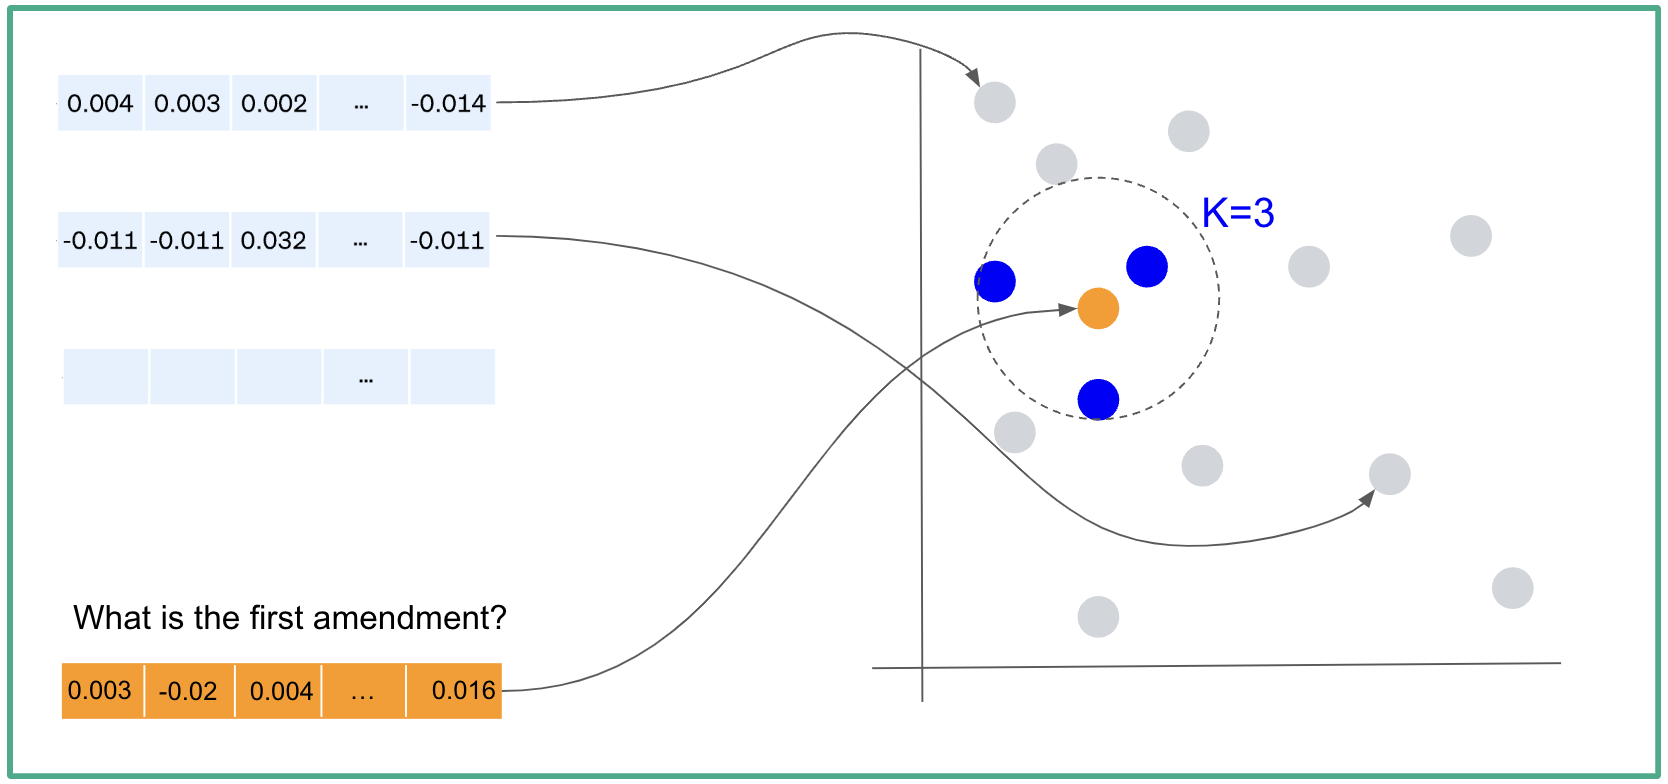

In [10]:
embeddings = OllamaEmbeddings(model="nomic-embed-text")
vectorstore = Chroma.from_documents(documents=documents_chunks, embedding=embeddings)

print(f"The vector store contains {len(vectorstore)} documents in total.")

The vector store contains 107 documents in total.


The documents are now contained in our vector store with their semantic vector. We can do a test by writing a question and seeing which documents will end up being selected. To observe this, you can execute the following cells which contain the `question` object which is compared with the documents stored in our vector store.

In [11]:
retriever = vectorstore.as_retriever()
question = "When was Ada Lovelace born?"
docs = retriever.get_relevant_documents(question)

/tmp/ipython-input-2920904690.py:3: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  docs = retriever.get_relevant_documents(question)


In [12]:
def show_docs(docs):
  print(f"To answer this question, the following {len(docs)} documents will be used.\n")
  for doc in docs:
    print_chunk(doc)
    print("\n")

show_docs(docs)

To answer this question, the following 4 documents will be used.

'''
Retrieved from "https://en.wikipedia.org/w/index.php?title=Ada_Lovelace&oldid=1312256926"
''' 89
{'source': 'Wikipedia Ada Lovelace, part_103'}


'''
Bicentenary (2015)
The bicentenary of Ada Lovelace's birth was celebrated with a number of events, including:[125]

The Ada Lovelace Bicentenary Lectures on Computability, Israel Institute for Advanced Studies, 20 December 2015 – 31 January 2016.[126][127]
Ada Lovelace Symposium, University of Oxford, 13–14 October 2015.[128]
Ada.Ada.Ada, a one-woman show about the life and work of Ada Lovelace (using an LED dress), premiered at Edinburgh International Science Festival on 11 April 2015,[129] and continued to touring internationally to promote diversity on STEM at technology conferences,[130][131] businesses, government and educational organisations.[132][133]
Special exhibitions were displayed by the Science Museum in London, England[134] and the Weston Library (part of

We can also observe the similarity score that the question had with the documents by executing the next cell. As a reminder, we use the Euclidean distance, so the smaller the distance, the more similar the documents are to the question!

In [13]:
results_with_scores = vectorstore.similarity_search_with_score(question)
for doc, score in results_with_scores:
    print(f"Metadata: {doc.metadata}, Score: {score}")

Metadata: {'source': 'Wikipedia Ada Lovelace, part_103'}, Score: 0.38267165422439575
Metadata: {'source': 'Wikipedia Ada Lovelace, part_58'}, Score: 0.47793054580688477
Metadata: {'source': 'Wikipedia Ada Lovelace, part_56'}, Score: 0.4959813952445984
Metadata: {'source': 'Wikipedia Ada Lovelace, part_54'}, Score: 0.511172354221344


## Step 5: Set up RAG

We now need to write the function that will be called by our small Chatbot and that will use the RAG to answer users's questions.

In [14]:
def get_important_facts(question):

  # Define the RAG setup
  retriever = vectorstore.as_retriever()

  # Fetch relevant document chunks based on a given query
  retrieved_docs = retriever.invoke(question)
  formatted_context = "\n\n".join(doc.page_content for doc in retrieved_docs)

  # Call the Ollama Llama3 model
  formatted_prompt = f"Question: {question}\n\nContext: {formatted_context}"
  response = ollama.chat(model='llama3', messages=[{'role': 'user', 'content': formatted_prompt}])

  return response['message']['content']

## Step 6: Implement Chatbot

The final step is to define a small user interface for our Chatbot, this can be done by using the Gradio library along with the RAG fuction defined in the previous step.

In [15]:
# Create a Gradio app interface
iface = gr.Interface(
  fn=get_important_facts,
  inputs=gr.Textbox(lines=2, placeholder="Enter your question here..."),
  outputs="text",
  title="RAG with Llama3",
  description="Ask questions about the proveded context",
)

In [16]:
# Launch the Gradio app
iface.launch()

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://a0454cd42f92a59c08.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
